In [8]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import utils.eval_funcs as eval_funcs
import matplotlib.colors 
import json
import analysis.fig_distrib_comparison_plot

In [9]:
colors = { 'Within' : 'magenta', 'Across' : 'cyan' }
stars_color = '#007bff'
bin_labels = ['Within', 'Across']

# Lethals in the TGI Dataset

In [10]:
smf_df = pd.read_csv('../generated-data/task_yeast_smf_30')
lethal_genes = set(smf_df[smf_df['bin'] == 0]['gene'])

In [11]:
tgi_df = pd.read_csv('../generated-data/task_ppc_yeast_pseudo_triplets')

In [12]:
tgi_genes = set(tgi_df['a']) | set(tgi_df['b']) | set(tgi_df['c'])

In [13]:
print("Lethals: %d" % len(lethal_genes))
print("Genes in TGI: %d" % len(tgi_genes))
print("Lethal genes in TGI: %d" % len(lethal_genes.intersection(tgi_genes)))

Lethals: 839
Genes in TGI: 1407
Lethal genes in TGI: 409


# SGO Terms

In [14]:
d = np.load('../generated-data/features/ppc_yeast_common_sgo.npz')

In [15]:
F = d['F']
terms = d['feature_labels']

with open('../generated-data/go_ids_to_names.json', 'r') as f:
    gene_ids_to_terms = json.load(f)

terms = [gene_ids_to_terms[t] for t in terms]

In [16]:
neg_df = tgi_df[tgi_df['bin'] == 0]

In [17]:
n_terms_shared = [[], []]
zero_terms = [0, 0]
for a_id, b_id, c_id, thebin in zip(tgi_df['a_id'], tgi_df['b_id'], tgi_df['c_id'], tgi_df['bin']):
    a_terms = F[a_id, :]
    b_terms = F[b_id, :]
    c_terms = F[c_id, :]
    thebin = int(thebin)
    
    shared = []
    for i in range(1, 4):
        n = np.sum((a_terms + b_terms + c_terms) >= i)
        shared.append(n)
    
    n_terms_shared[thebin].append(shared)
    
    n_zero_terms = np.sum((a_terms + b_terms + c_terms) == 0) == F.shape[1]
    zero_terms[thebin] += n_zero_terms 
zero_terms

[25, 0]

In [18]:
neg_n_terms = np.array(n_terms_shared[0])
net_n_terms = np.array(n_terms_shared[1])

In [20]:
threshold = 2
max_N = np.maximum(np.max(neg_n_terms[:,threshold-1]), np.max(net_n_terms[:,threshold-1]))
R = np.zeros((2, max_N+1))
for thebin in [0, 1]:
    class_terms = neg_n_terms if thebin == 0 else net_n_terms
    for n_terms_shared in range(R.shape[1]):
        R[thebin, n_terms_shared] = np.sum(class_terms[:,threshold-1] == n_terms_shared)

rows = []
for thebin in range(R.shape[0]):
    for n_terms_shared in range(max_N):
        y = R[thebin, n_terms_shared] * 100 / np.sum(R[thebin, :])
        rows.append({
            "hue" : bin_labels[thebin],
            "x" : n_terms_shared,
            "y" : y,
            "raw_y" : R[thebin, n_terms_shared]
        })
df = pd.DataFrame(rows)

[[2.200e+02 1.633e+03]
 [1.779e+03 2.381e+03]
 [1.461e+03 7.820e+02]
 [1.143e+03 1.850e+02]
 [3.690e+02 1.800e+01]
 [2.600e+01 1.000e+00]]
[[1853.]
 [4160.]
 [2243.]
 [1328.]
 [ 387.]
 [  27.]]
[[4998. 5000.]]
[[ 926.31466293  926.68533707]
 [2079.58391678 2080.41608322]
 [1121.27565513 1121.72434487]
 [ 663.86717343  664.13282657]
 [ 193.46129226  193.53870774]
 [  13.49729946   13.50270054]]


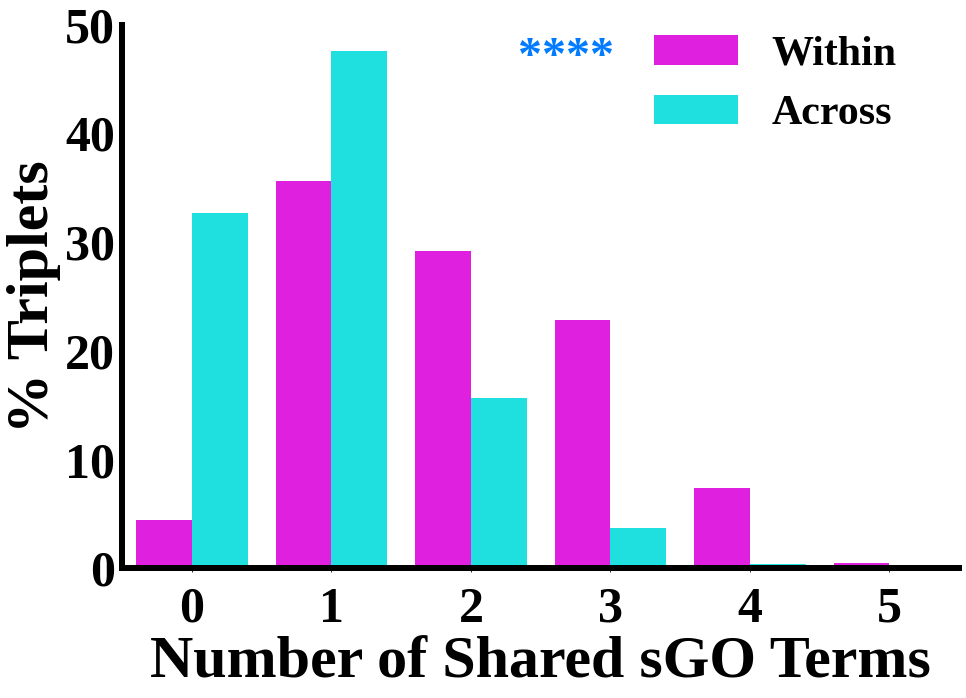

In [25]:
analysis.fig_distrib_comparison_plot.plot_distrib(df, colors, 
    'Number of Shared sGO Terms', '% Triplets', 5,
    [0, 50], stars_color, "../figures/yeast_pseudo_triplets_sgo.png", legend_pos=(0.97, 1.05))

# Shortest Path Length

In [26]:
d = np.load('../generated-data/pairwise_features/ppc_yeast_shortest_path_len.npy')

In [27]:
scls = [[], []]
for a_id, b_id, c_id, thebin in zip(tgi_df['a_id'], tgi_df['b_id'], tgi_df['c_id'], tgi_df['bin']):
    
    thebin = int(thebin)
    
    ab_spl = d[a_id, b_id]
    ac_spl = d[a_id, c_id]
    bc_spl = d[b_id, c_id]
    scl = np.sum([ab_spl, ac_spl, bc_spl])
    scls[thebin].append(scl)
scls[0] = np.array(scls[0])
scls[1] = np.array(scls[1])

[[2.748e+03 0.000e+00]
 [7.390e+02 7.000e+00]
 [5.400e+02 7.100e+01]
 [8.760e+02 9.090e+02]
 [5.500e+01 1.044e+03]
 [3.000e+01 1.604e+03]
 [1.000e+01 8.940e+02]
 [1.000e+00 3.350e+02]
 [0.000e+00 8.700e+01]
 [1.000e+00 3.000e+01]
 [0.000e+00 9.000e+00]
 [0.000e+00 8.000e+00]
 [0.000e+00 1.000e+00]
 [0.000e+00 1.000e+00]]
[[2.748e+03]
 [7.460e+02]
 [6.110e+02]
 [1.785e+03]
 [1.099e+03]
 [1.634e+03]
 [9.040e+02]
 [3.360e+02]
 [8.700e+01]
 [3.100e+01]
 [9.000e+00]
 [8.000e+00]
 [1.000e+00]
 [1.000e+00]]
[[5000. 5000.]]
[[1.374e+03 1.374e+03]
 [3.730e+02 3.730e+02]
 [3.055e+02 3.055e+02]
 [8.925e+02 8.925e+02]
 [5.495e+02 5.495e+02]
 [8.170e+02 8.170e+02]
 [4.520e+02 4.520e+02]
 [1.680e+02 1.680e+02]
 [4.350e+01 4.350e+01]
 [1.550e+01 1.550e+01]
 [4.500e+00 4.500e+00]
 [4.000e+00 4.000e+00]
 [5.000e-01 5.000e-01]
 [5.000e-01 5.000e-01]]


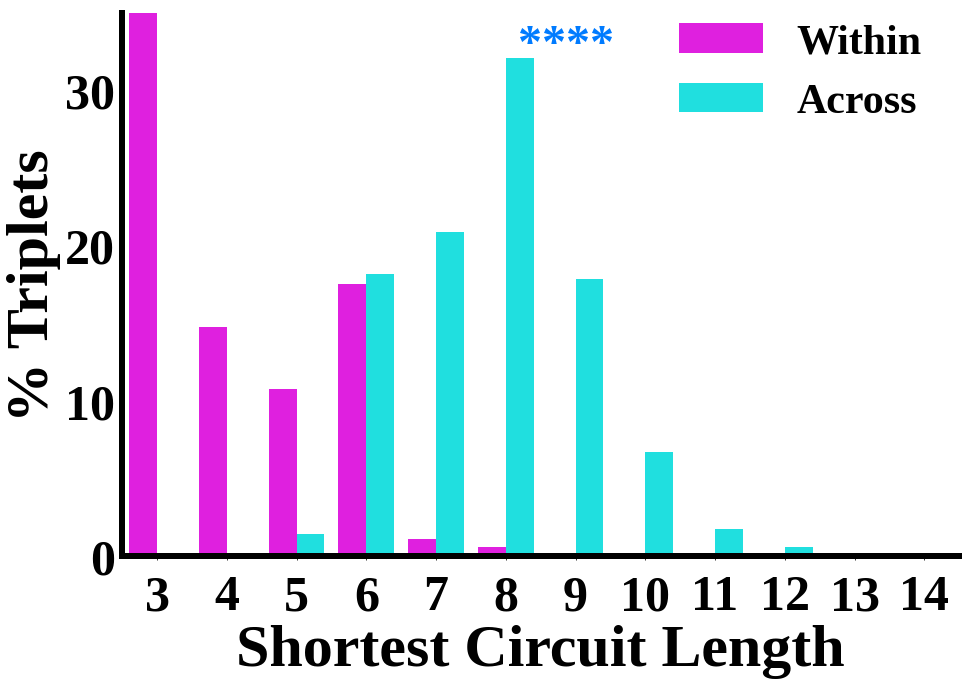

In [28]:
max_circuit_length = np.maximum(np.max(scls[0]), np.max(scls[1]))
min_circuit_length = np.minimum(np.min(scls[0]), np.min(scls[1]))
n_categories = int(max_circuit_length - min_circuit_length + 1)

R = np.zeros((2, n_categories))
for thebin in [0, 1]:
    for i, scl in enumerate(np.arange(min_circuit_length, max_circuit_length + 1)):
        R[thebin, i] = np.sum(scls[thebin] == scl)

rows = []
for thebin in range(R.shape[0]):
    for i in range(R.shape[1]):
        y = R[thebin, i] * 100 / np.sum(R[thebin, :])
        rows.append({
            "hue" : bin_labels[thebin],
            "x" : int(min_circuit_length + i),
            "y" : y,
            "raw_y" : R[thebin, i]
        })
df = pd.DataFrame(rows)
analysis.fig_distrib_comparison_plot.plot_distrib(df, colors, 
                                                  'Shortest Circuit Length', '% Triplets', 0,
                                                 [0, 35], stars_color, "../figures/yeast_pseudo_triplets_scl_details.png",
                                                 xlim=[-0.5, 11.5])

# SCL Summary

[[  42. 2969.]
 [4958. 2031.]]
[[3011.]
 [6989.]]
[[5000. 5000.]]
[[1505.5 1505.5]
 [3494.5 3494.5]]


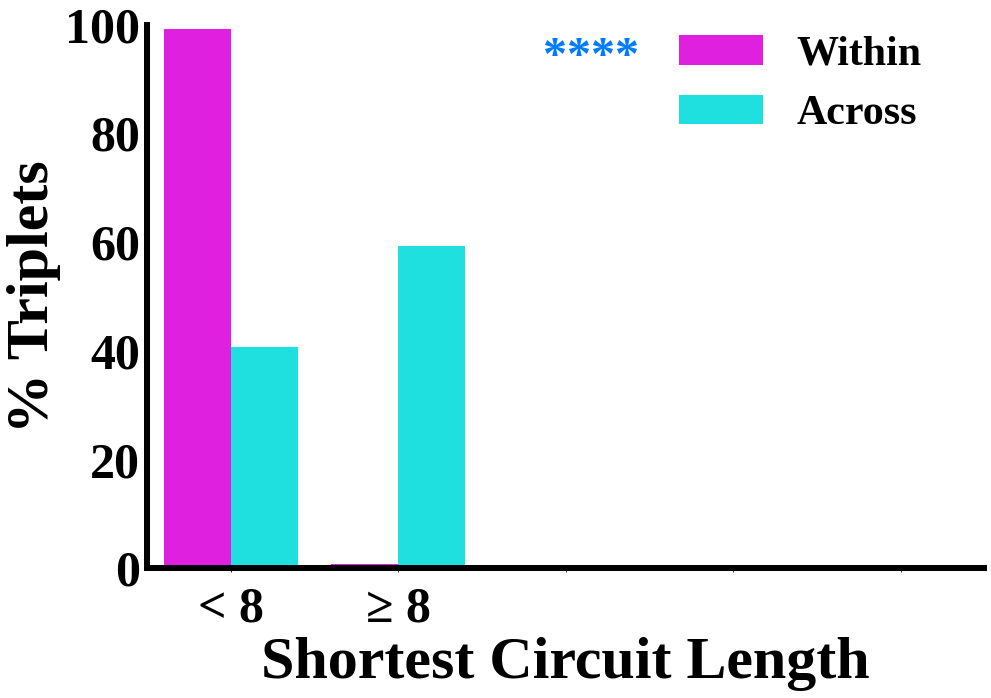

In [32]:

cutoff = 8
R = np.array([
    [ np.sum(np.array(scls[0]) < cutoff), np.sum(np.array(scls[0]) >= 8) ],
    [ np.sum(np.array(scls[1]) < cutoff), np.sum(np.array(scls[1]) >= 8) ],
])

rows = []
for thebin in range(R.shape[0]):
    for k, lbl in enumerate(['< %d' % cutoff, '≥ %d' % cutoff]):
        y = R[thebin, k] * 100 / np.sum(R[thebin, :])
        rows.append({
            "hue" : bin_labels[thebin],
            "x" : lbl,
            "y" : y,
            "raw_y" : R[thebin, k]
        })
df = pd.DataFrame(rows)
analysis.fig_distrib_comparison_plot.plot_distrib(df, colors, 
    'Shortest Circuit Length', '% Triplets', 5,
    [0, 100], stars_color, "../figures/yeast_pseudo_triplets_scl_summary.png", legend_pos=(0.97, 1.05))